In [1]:
import sys
import os

if sys.version_info[0] < 3:
  print('[ERROR] You need to run this with Python 3.')
  raise AssertionError

In [2]:
import numpy as np

from emtf_algos import *
from emtf_logger import *

In [3]:
# Set random seed
np.random.seed(2027)

import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras import layers as k_layers
from tensorflow.keras import backend as k_backend
import matplotlib as mpl
import matplotlib.pyplot as plt

# Set random seed
tf.random.set_seed(2027)

#import numba
#from numba import njit, vectorize
#import dask
#import dask.array as da

logger = get_logger()
logger.info('Using cmssw      : {0}'.format(os.environ['CMSSW_VERSION'] if 'CMSSW_VERSION' in os.environ else 'n/a'))
logger.info('Using python     : {0}'.format(sys.version.replace('\n', '')))
logger.info('Using numpy      : {0}'.format(np.__version__))
logger.info('Using tensorflow : {0}'.format(tf.__version__))
logger.info('Using keras      : {0}'.format(keras.__version__))
logger.info('.. list devices  : {0}'.format(tf.config.list_physical_devices()))
logger.info('Using matplotlib : {0}'.format(mpl.__version__))
#logger.info('Using numba      : {0}'.format(numba.__version__))
#logger.info('Using dask       : {0}'.format(dask.__version__))

assert k_backend.backend() == 'tensorflow'
assert k_backend.image_data_format() == 'channels_last'

%matplotlib inline

[INFO    ] Using cmssw      : CMSSW_10_6_3
[INFO    ] Using python     : 3.6.10 |Anaconda, Inc.| (default, May  8 2020, 02:54:21) [GCC 7.3.0]
[INFO    ] Using numpy      : 1.18.5
[INFO    ] Using tensorflow : 2.2.0
[INFO    ] Using keras      : 2.3.0-tf
[INFO    ] .. list devices  : [PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:XLA_CPU:0', device_type='XLA_CPU')]
[INFO    ] Using matplotlib : 3.2.2


In [4]:
# Settings

# zone: (0,1,2) -> eta=(1.98..2.5, 1.55..1.98, 1.2..1.55)
zone = 0
#zone = 1
#zone = 2

# timezone: (0,1,2) -> BX=(-1,0,+1)
timezone = 1

maxevents = 1000
#maxevents = -1

# Input files
patterns_fname = 'patterns_zone%i.npz' % zone
zone_images_fname = 'zone_images_zone%i.h5' % zone

#logger.info('Processing zone {0} timezone {1}'.format(zone, timezone))
#logger.info('.. maxevents        : {0}'.format(maxevents))

In [5]:
# Styling
plt.style.use('tdrstyle.mplstyle')

# Color maps
from matplotlib.colors import ListedColormap
my_cmap = ListedColormap(plt.cm.viridis.colors, name='viridis_mod')
my_cmap.set_under('w',1)

from matplotlib.colors import LinearSegmentedColormap
cdict = {
  'blue' : ((0.0, 0.0416, 0.0416), (0.365079, 1.0, 1.0), (1.0, 1.0, 1.0)),
  'green': ((0.0, 0.0, 0.0), (0.365079, 0.0, 0.0), (0.746032, 1.0, 1.0), (1.0, 1.0, 1.0)),
  'red'  : ((0.0, 0.0, 0.0), (0.746032, 0.0, 0.0), (1.0, 1.0, 1.0)),
}
blue_hot = LinearSegmentedColormap('blue_hot', cdict)

cdict = {
  'blue' : ((0.0, 0.0, 0.0), (0.365079, 0.0, 0.0), (0.746032, 1.0, 1.0), (1.0, 1.0, 1.0)),
  'green': ((0.0, 0.0416, 0.0416), (0.365079, 1.0, 1.0), (1.0, 1.0, 1.0)),
  'red'  : ((0.0, 0.0, 0.0), (0.746032, 0.0, 0.0), (1.0, 1.0, 1.0)),
}
green_hot = LinearSegmentedColormap('green_hot', cdict)

### Load data

In [6]:
def load_patterns(fname):
  logger.info('Loading from {0}'.format(fname))
  with np.load(fname) as loaded:
    patterns = loaded['patterns']
    boxes_act = loaded['boxes_act']
    logger.info('patterns: {0} boxes_act: {1}'.format(patterns.shape, boxes_act.shape))
  return (patterns, boxes_act)

import h5py
loaded_h5 = None  # hdf5 file handle

def load_zone_sparse_images(fname):
  global loaded_h5
  if loaded_h5 is None:
    logger.info('Loading from {0}'.format(fname))
    loaded_h5 = h5py.File(fname, 'r')
  zone_box_anchors = loaded_h5['zone_box_anchors']
  zone_sparse_images = SparseTensorValue(indices=loaded_h5['zone_sparse_images_indices'],
                                         values=loaded_h5['zone_sparse_images_values'],
                                         dense_shape=loaded_h5['zone_sparse_images_dense_shape'])
  logger.info('zone_box_anchors: {0} zone_sparse_images: {1}'.format(zone_box_anchors.shape, zone_sparse_images.dense_shape))
  return zone_box_anchors, zone_sparse_images

In [7]:
def sparse_to_dense_quick(sparse, maxevents):
  dense_shape = (maxevents,) + sparse.dense_shape[1:]
  dense = np.zeros(dense_shape, dtype=sparse.dtype)
  for i in range(len(sparse.indices)):
    if sparse.indices[i, 0] >= maxevents:
      break
    tup = tuple(sparse.indices[i])
    dense[tup] = sparse.values[i]
  return dense

In [8]:
patterns, boxes_act = load_patterns(patterns_fname)

boxes_act_test = boxes_act[3]  # use only the prompt muon row
boxes_act_test = np.moveaxis(boxes_act_test, 0, -1)  # put num_patterns at the last axis

logger.info('boxes_act_test: {0}'.format(boxes_act_test.shape))

[INFO    ] Loading from patterns_zone0.npz
[INFO    ] patterns: (7, 7, 8, 3) boxes_act: (7, 7, 8, 111, 1)
[INFO    ] boxes_act_test: (8, 111, 1, 7)


In [9]:
zone_box_anchors, zone_sparse_images = load_zone_sparse_images(zone_images_fname)

zone_images_test = sparse_to_dense_quick(zone_sparse_images, maxevents)
zone_box_anchors_test = zone_box_anchors[:maxevents]

logger.info('zone_images_test: {0} zone_box_anchors_test: {1}'.format(zone_images_test.shape, zone_box_anchors_test.shape))

[INFO    ] Loading from zone_images_zone0.h5
[INFO    ] zone_box_anchors: (761923,) zone_sparse_images: (761923, 8, 288, 1)
[INFO    ] zone_images_test: (1000, 8, 288, 1) zone_box_anchors_test: (1000,)


In [10]:
# Image format & box image format
image_format = zone_images_test.shape[1:]
box_image_format = boxes_act_test.shape[:-1]
(num_rows, num_cols, num_channels) = image_format
(num_box_rows, num_box_cols, num_box_channels) = box_image_format
box_col_offset = (num_box_cols-1)//2  # (111-1)/2 = 55
num_patterns = boxes_act_test.shape[-1]

logger.info('Processing zone {0} timezone {1}'.format(zone, timezone))
logger.info('.. maxevents        : {0}'.format(maxevents))
logger.info('.. image_format     : {0}'.format(image_format))
logger.info('.. box_image_format : {0}'.format(box_image_format))
logger.info('.. num_patterns     : {0}'.format(num_patterns))

[INFO    ] Processing zone 0 timezone 1
[INFO    ] .. maxevents        : 1000
[INFO    ] .. image_format     : (8, 288, 1)
[INFO    ] .. box_image_format : (8, 111, 1)
[INFO    ] .. num_patterns     : 7


### Create model (part 1)

In [11]:
def create_dummy_model():
  # Input
  inputs = keras.Input(shape=(num_rows, num_cols, num_channels))
  x = inputs

  # Dummy layer
  x = k_layers.Conv2D(filters=1, kernel_size=(1, 1), strides=(1, 1), use_bias=False)(x)
  x = k_layers.MaxPooling2D(pool_size=(1, 1), strides=(1, 1))(x)

  # Output
  outputs = x

  # Model
  model = keras.Model(inputs=inputs, outputs=outputs, name='dummy_model')

  # Summary
  model.summary()
  return model

def create_model():
  # Input
  inputs = keras.Input(shape=(num_rows, num_cols, num_channels))
  x = inputs

  # Transpose the input, exchanging row <-> channel
  x = tf.transpose(x, perm=(0, 3, 2, 1))  # NHWC -> NCWH

  # Conv2D
  # See: https://www.tensorflow.org/api_docs/python/tf/keras/layers/DepthwiseConv2D
  # See: https://www.tensorflow.org/api_docs/python/tf/keras/layers/SeparableConv2D
  from k_layers_separable_conv2d import SeparableConv2D as MySeparableConv2D
  conv2d_kwargs = dict(filters=1, kernel_size=(1, num_box_cols), depth_multiplier=num_patterns,
                       strides=(1, 1), padding='same', activation=None, use_bias=False, trainable=False)
  x = MySeparableConv2D(**conv2d_kwargs)(x)

  # Reshape + reverse transpose
  x = tf.reshape(x, [-1, num_channels, num_cols, num_rows, num_patterns])
  x = tf.transpose(x, perm=(0, 3, 2, 1, 4))  # NCWHX -> NHWCX
  x = tf.reshape(x, [-1, num_rows, num_cols, num_channels * num_patterns])

  # Output
  outputs = x

  # Model
  model = keras.Model(inputs=inputs, outputs=outputs, name='awesome_model')

  # Summary
  model.summary()
  return model

In [12]:
def save_my_model(model, name=None):
  if not name:
    name = model.name
  # Store model to file
  model_name, model_weights_name, model_json_name = (name + '.h5'), (name + '_weights.h5'), (name + '.json')
  model.save(model_name)
  model.save_weights(model_weights_name)
  # Store model to json
  with open(model_json_name, 'w') as f:
    f.write(model.to_json())
  logger.info('Wrote to {0}, {1}, {2}'.format(model_name, model_weights_name, model_json_name))
  return

In [13]:
# Create model

model = create_model()

Model: "awesome_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 8, 288, 1)]       0         
_________________________________________________________________
tf_op_layer_Transpose (Tenso [(None, 1, 288, 8)]       0         
_________________________________________________________________
separable_conv2d (SeparableC (None, 1, 288, 56)        6272      
_________________________________________________________________
tf_op_layer_Reshape (TensorF [(None, 1, 288, 8, 7)]    0         
_________________________________________________________________
tf_op_layer_Transpose_1 (Ten [(None, 8, 288, 1, 7)]    0         
_________________________________________________________________
tf_op_layer_Reshape_1 (Tenso [(None, 8, 288, 7)]       0         
Total params: 6,272
Trainable params: 0
Non-trainable params: 6,272
___________________________________________________

In [14]:
# Load model weights

model_weights = model.get_weights()
#print(len(model_weights))

from collections import defaultdict
model_weights_w_names = defaultdict(list)

# Loop over layer weights
i = 0
for model_layer in model.layers:
  for _ in model_layer.weights:
    print('layer {0}. {1}: {2}'.format(i, model_layer.name, model_weights[i].shape))
    model_weights_w_names[model_layer.name].append(model_weights[i])
    i += 1

depthwise_kernel_weights = np.transpose(boxes_act_test, [2, 1, 0, 3])
pointwise_kernel_weights = np.ones((1, 1, num_rows * num_patterns, 1), dtype=np.float32)

assert len(model_weights) == 2
assert model_weights[0].shape == depthwise_kernel_weights.shape
assert model_weights[1].shape == pointwise_kernel_weights.shape

# Set weights
model.set_weights([depthwise_kernel_weights, pointwise_kernel_weights])

layer 0. separable_conv2d: (1, 111, 8, 7)
layer 1. separable_conv2d: (1, 1, 56, 1)


In [15]:
# Inference

zone_featmaps_test = model(zone_images_test)
zone_featmaps_test = zone_featmaps_test.numpy().astype(np.bool)

print('zone_featmaps_test: {0}'.format(zone_featmaps_test.shape))

zone_featmaps_test: (1000, 8, 288, 7)


### Results

In [16]:
# Display images

def display_image(img, cmap=blue_hot, figsize=(10,2)):
  fig, ax = plt.subplots(1, 1, figsize=figsize)
  ax.imshow(img[...,0], origin='lower', interpolation='none', aspect='auto',
            cmap=cmap, vmin=0, vmax=1.6)
  ax.set_yticks(range(len(zo_layer_labels[zone])))
  ax.set_yticklabels(zo_layer_labels[zone], fontsize=7)
  ax.grid(False)
  plt.show()

Event 0


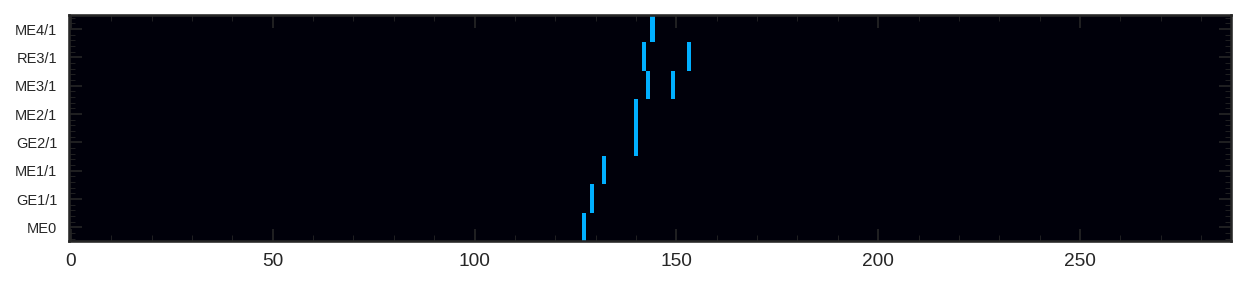

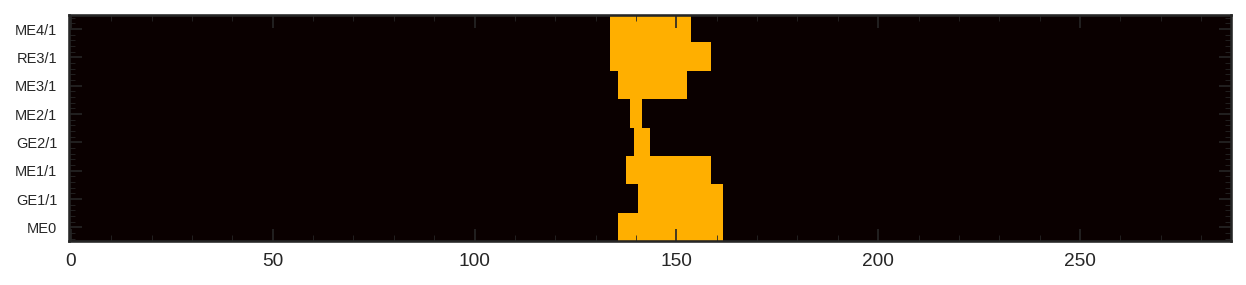

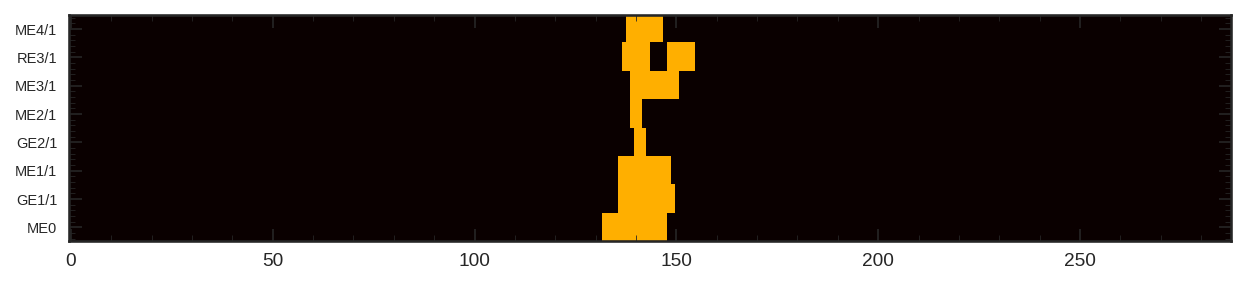

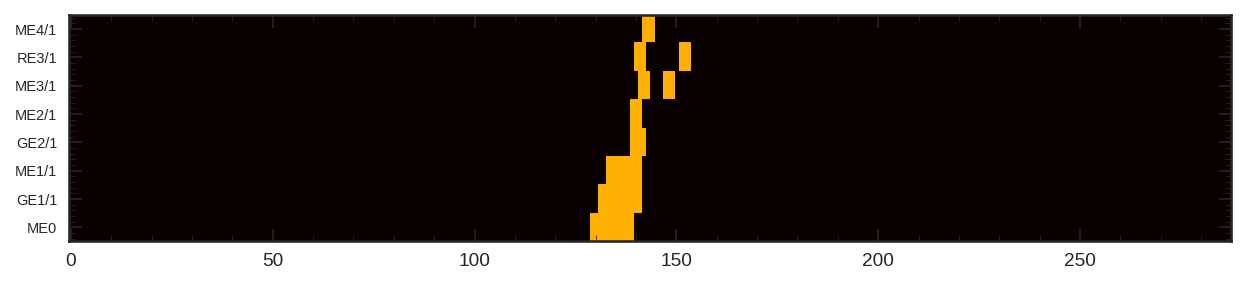

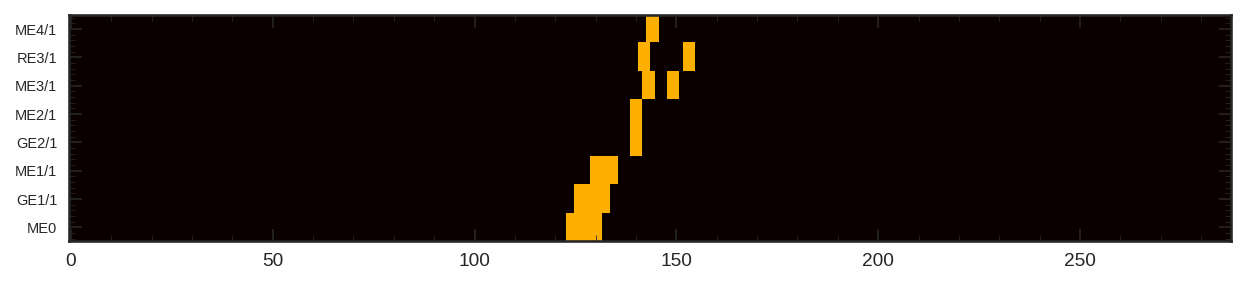

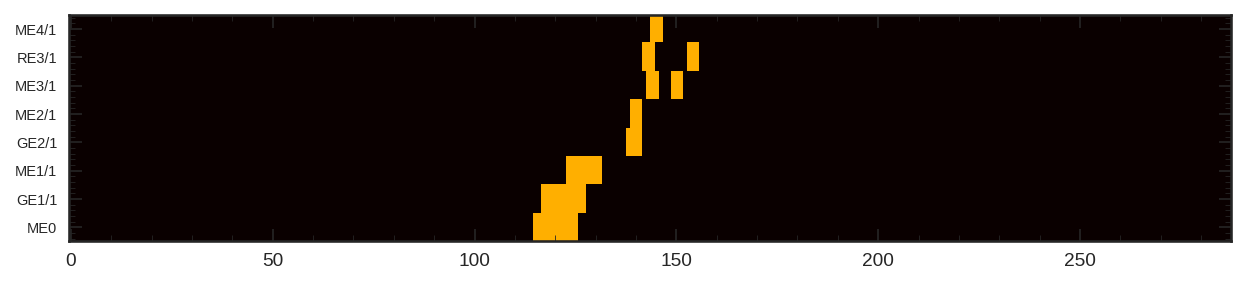

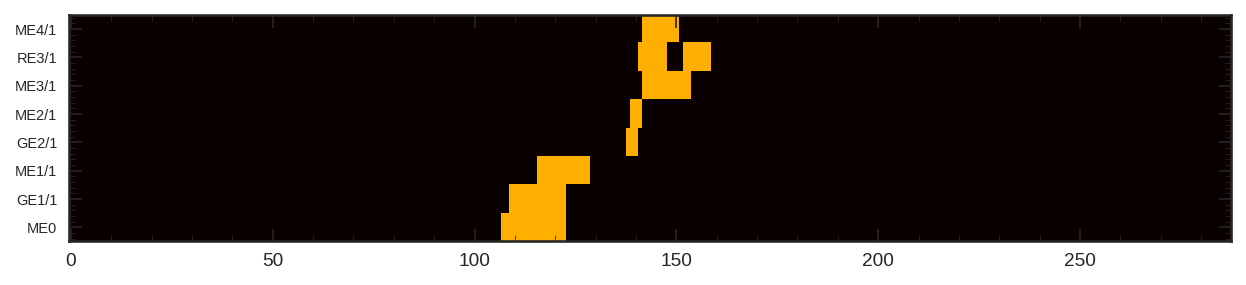

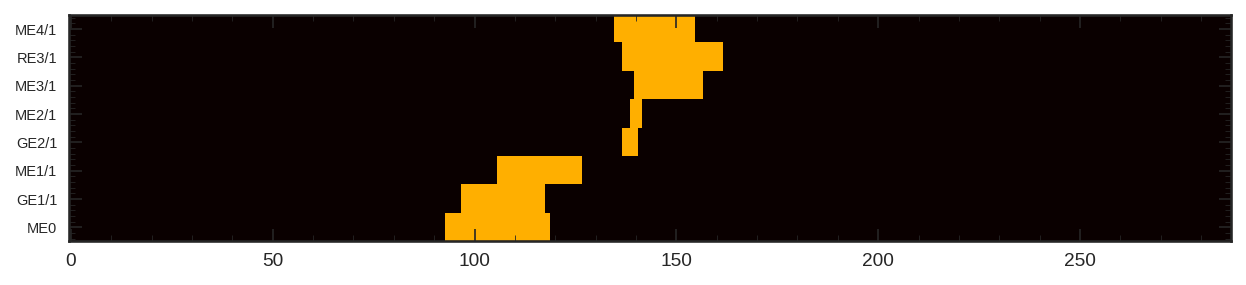

(array([0, 1, 2, 3, 4, 5, 5, 6, 6, 7]), array([127, 129, 132, 140, 140, 143, 149, 142, 153, 144]), array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0]))
(array([0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2,
       2, 2, 2, 3, 3, 3, 4, 4, 4, 5, 5, 5, 5, 5, 5, 6, 6, 6, 6, 6, 6, 7,
       7, 7]), array([123, 124, 125, 126, 127, 128, 129, 130, 131, 125, 126, 127, 128,
       129, 130, 131, 132, 133, 129, 130, 131, 132, 133, 134, 135, 139,
       140, 141, 139, 140, 141, 142, 143, 144, 148, 149, 150, 141, 142,
       143, 152, 153, 154, 143, 144, 145]), array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0]))


In [17]:
# Debug
for ievt in range(1):
  print('Event {0}'.format(ievt))
  img = zone_images_test[ievt]
  fmap = zone_featmaps_test[ievt]

  display_image(img)
  for j in range(num_patterns):
    display_image(fmap[..., j:j+1], cmap=plt.cm.hot)
  print(img.nonzero())
  print(fmap[..., 3:4].nonzero())

Event 2


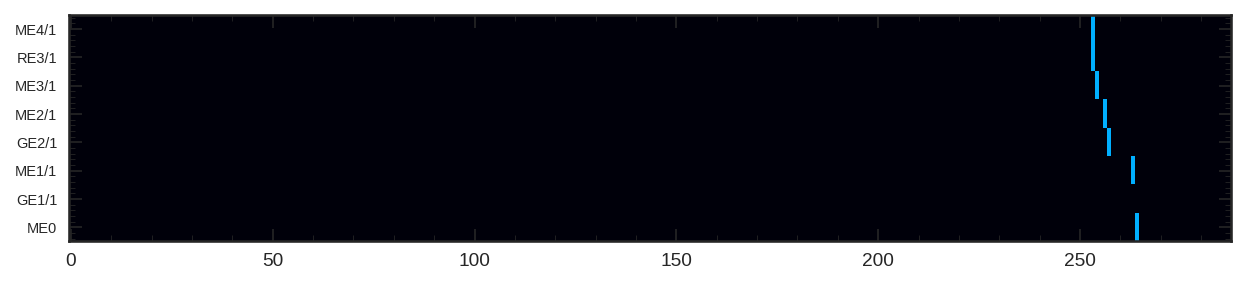

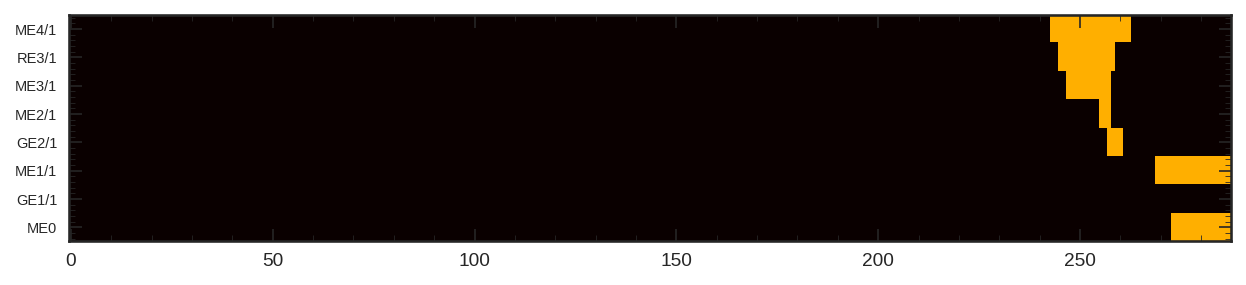

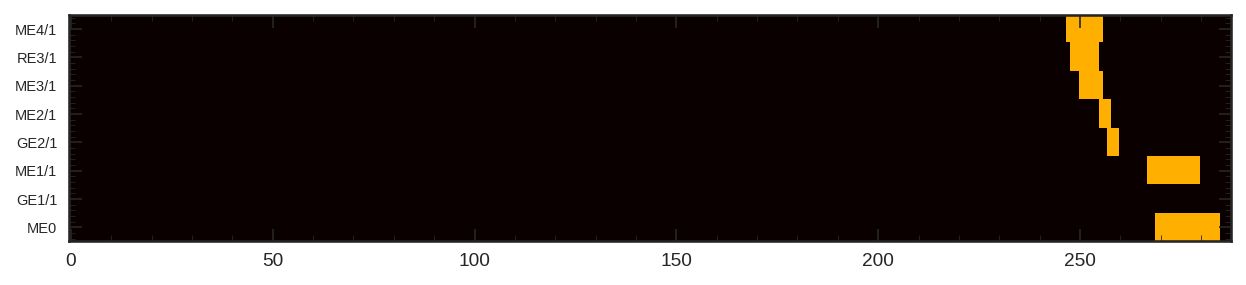

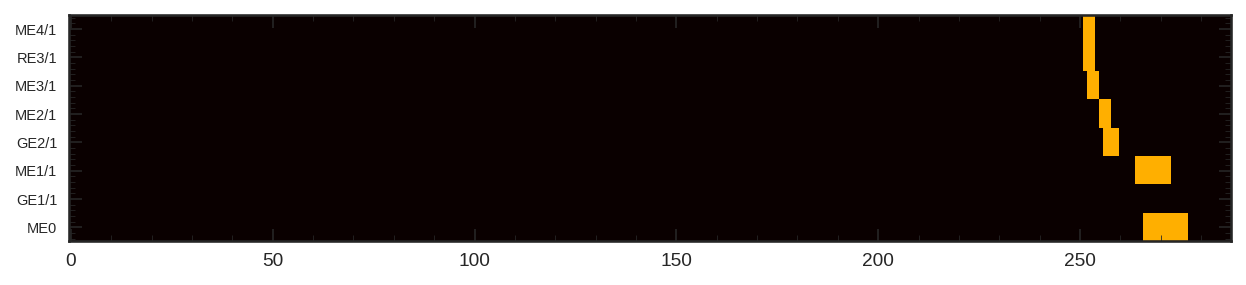

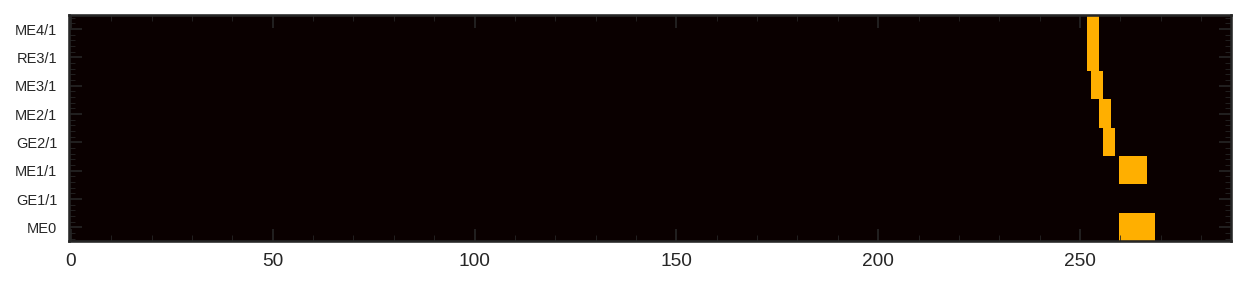

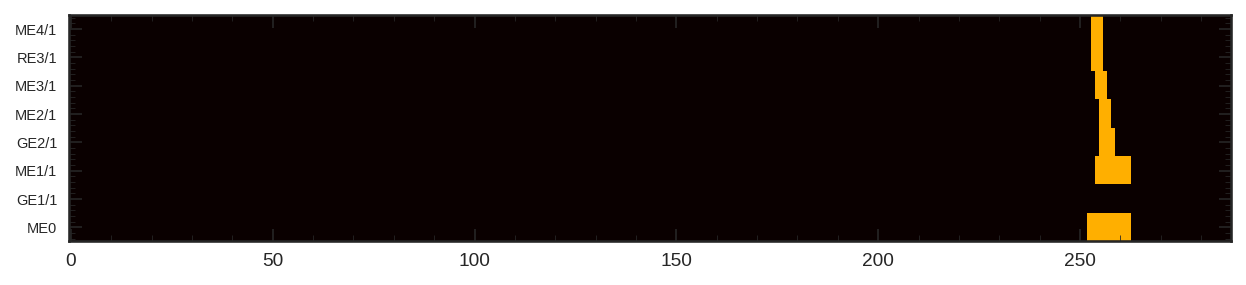

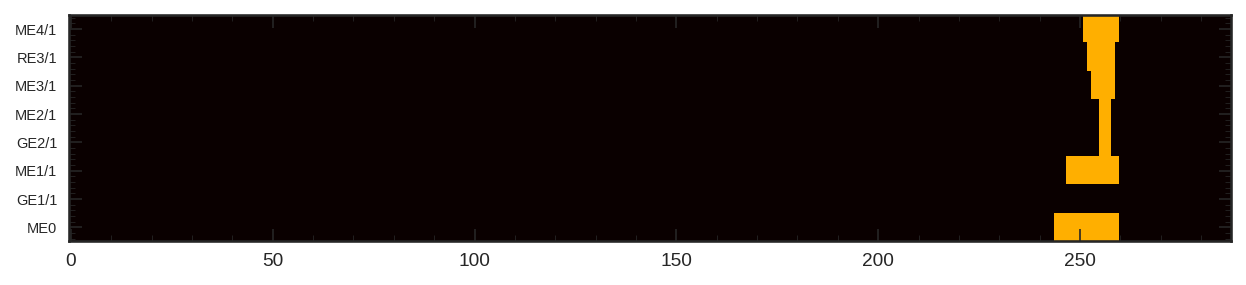

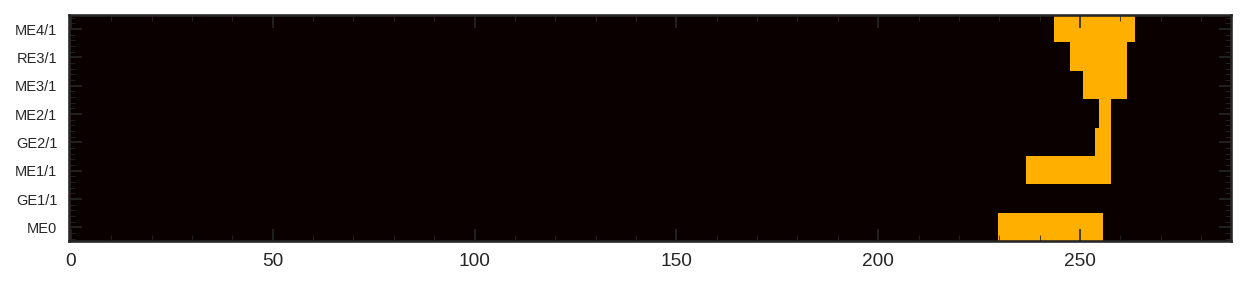

(array([0, 2, 3, 4, 5, 6, 7]), array([264, 263, 257, 256, 254, 253, 253]), array([0, 0, 0, 0, 0, 0, 0]))
(array([0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 4, 4, 4,
       5, 5, 5, 6, 6, 6, 7, 7, 7]), array([260, 261, 262, 263, 264, 265, 266, 267, 268, 260, 261, 262, 263,
       264, 265, 266, 256, 257, 258, 255, 256, 257, 253, 254, 255, 252,
       253, 254, 252, 253, 254]), array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0]))


In [18]:
# Debug
for ievt in range(2,3):
  print('Event {0}'.format(ievt))
  img = zone_images_test[ievt]
  fmap = zone_featmaps_test[ievt]

  display_image(img)
  for j in range(num_patterns):
    display_image(fmap[..., j:j+1], cmap=plt.cm.hot)
  print(img.nonzero())
  print(fmap[..., 3:4].nonzero())

### Export data

In [19]:
for ievt in range(3):
  print('Event {0}'.format(ievt))
  img = zone_images_test[ievt]
  fmap = zone_featmaps_test[ievt]
  s_img = dense_to_sparse(img)
  s_fmap = dense_to_sparse(fmap)
  print('img. dense_shape: {0} nnz: {1}'.format(s_img.dense_shape, s_img.indices.shape[0]))
  print(np.flatnonzero(img))
  print(np.array2string(s_img.indices[:, 0], separator=', ', threshold=1000))
  print(np.array2string(s_img.indices[:, 1], separator=', ', threshold=1000))
  print(np.array2string(s_img.indices[:, 2], separator=', ', threshold=1000))
  print('fmap. dense_shape: {0} nnz: {1}'.format(s_fmap.dense_shape, s_fmap.indices.shape[0]))
  #print(np.flatnonzero(fmap))
  #print(np.array2string(s_fmap.indices[:, 0], separator=', ', threshold=1000))
  #print(np.array2string(s_fmap.indices[:, 1], separator=', ', threshold=1000))
  #print(np.array2string(s_fmap.indices[:, 2], separator=', ', threshold=1000))
  print()

Event 0
img. dense_shape: (8, 288, 1) nnz: 10
[ 127  417  708 1004 1292 1583 1589 1870 1881 2160]
[0, 1, 2, 3, 4, 5, 5, 6, 6, 7]
[127, 129, 132, 140, 140, 143, 149, 142, 153, 144]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
fmap. dense_shape: (8, 288, 7) nnz: 594

Event 1
img. dense_shape: (8, 288, 1) nnz: 7
[  63  645  947 1237 1532 2109 2110]
[0, 2, 3, 4, 5, 7, 7]
[63, 69, 83, 85, 92, 93, 94]
[0, 0, 0, 0, 0, 0, 0]
fmap. dense_shape: (8, 288, 7) nnz: 371

Event 2
img. dense_shape: (8, 288, 1) nnz: 7
[ 264  839 1121 1408 1694 1981 2269]
[0, 2, 3, 4, 5, 6, 7]
[264, 263, 257, 256, 254, 253, 253]
[0, 0, 0, 0, 0, 0, 0]
fmap. dense_shape: (8, 288, 7) nnz: 402



In [20]:
class Exporter(object):
  def encode_img(self, img):
    # Pack bits, flatten, and convert to a sparse array
    orig_shape = img.shape
    s_img = dense_to_sparse(np.reshape((np.packbits(img, axis=0)), -1))
    indices, values, dense_shape = np.squeeze(s_img.indices), s_img.values, s_img.dense_shape
    return (indices, values, dense_shape, orig_shape)

  def decode_img(self, indices, values, dense_shape, orig_shape):
    # Convert back to a dense array, unpack bits (and roll axis), reshape to orig shape
    indices = np.expand_dims(indices, axis=-1)
    dense_shape = np.asarray(dense_shape)
    s_img = SparseTensorValue(indices=indices, values=values, dense_shape=dense_shape)
    img = sparse_to_dense(s_img)
    img = np.reshape(np.unpackbits(img), img.shape + (-1,))
    img = np.moveaxis(img, -1, 0)
    img = np.reshape(img, orig_shape)
    return img

exporter = Exporter()

In [21]:
for ievt in range(3):
  print('Event {0}'.format(ievt))
  img = zone_images_test[ievt]
  fmap = zone_featmaps_test[ievt]

  img_1 = exporter.decode_img(*exporter.encode_img(img))
  fmap_1 = exporter.decode_img(*exporter.encode_img(fmap))
  s_img_1 = dense_to_sparse(img_1)
  s_fmap_1 = dense_to_sparse(fmap_1)

  print('img. dense_shape: {0} nnz: {1}'.format(s_img_1.dense_shape, s_img_1.indices.shape[0]))
  print(np.flatnonzero(img_1))
  print(np.array2string(s_img_1.indices[:, 0], separator=', ', threshold=1000))
  print(np.array2string(s_img_1.indices[:, 1], separator=', ', threshold=1000))
  print(np.array2string(s_img_1.indices[:, 2], separator=', ', threshold=1000))
  print('fmap. dense_shape: {0} nnz: {1}'.format(s_fmap_1.dense_shape, s_fmap_1.indices.shape[0]))
  #print(np.flatnonzero(fmap_1))
  #print(np.array2string(s_fmap_1.indices[:, 0], separator=', ', threshold=1000))
  #print(np.array2string(s_fmap_1.indices[:, 1], separator=', ', threshold=1000))
  #print(np.array2string(s_fmap_1.indices[:, 2], separator=', ', threshold=1000))
  print()

  assert np.all(img == img_1)
  assert np.all(fmap == fmap_1)

Event 0
img. dense_shape: (8, 288, 1) nnz: 10
[ 127  417  708 1004 1292 1583 1589 1870 1881 2160]
[0, 1, 2, 3, 4, 5, 5, 6, 6, 7]
[127, 129, 132, 140, 140, 143, 149, 142, 153, 144]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
fmap. dense_shape: (8, 288, 7) nnz: 594

Event 1
img. dense_shape: (8, 288, 1) nnz: 7
[  63  645  947 1237 1532 2109 2110]
[0, 2, 3, 4, 5, 7, 7]
[63, 69, 83, 85, 92, 93, 94]
[0, 0, 0, 0, 0, 0, 0]
fmap. dense_shape: (8, 288, 7) nnz: 371

Event 2
img. dense_shape: (8, 288, 1) nnz: 7
[ 264  839 1121 1408 1694 1981 2269]
[0, 2, 3, 4, 5, 6, 7]
[264, 263, 257, 256, 254, 253, 253]
[0, 0, 0, 0, 0, 0, 0]
fmap. dense_shape: (8, 288, 7) nnz: 402



In [22]:
# Export data

for ievt in range(3):
  print('Event {0}'.format(ievt))
  img = zone_images_test[ievt]
  fmap = zone_featmaps_test[ievt]
  enc_img = exporter.encode_img(img)
  enc_fmap = exporter.encode_img(fmap)
  print('img. dense_shape: {0} nnz: {1}'.format(enc_img[2], enc_img[0].shape[0]))
  print(np.array2string(enc_img[0], separator=', ', threshold=1000))
  print(np.array2string(enc_img[1], separator=', ', threshold=1000))
  print('fmap. dense_shape: {0} nnz: {1}'.format(enc_fmap[2], enc_fmap[0].shape[0]))
  print(np.array2string(enc_fmap[0], separator=', ', threshold=1000))
  print(np.array2string(enc_fmap[1], separator=', ', threshold=1000))
  print()

Event 0
img. dense_shape: (288,) nnz: 9
[127, 129, 132, 140, 142, 143, 144, 149, 153]
[128,  64,  32,  24,   2,   4,   1,   4,   2]
fmap. dense_shape: (2016,) nnz: 235
[ 657,  664,  671,  678,  685,  692,  699,  706,  713,  720,  727,  734,
  741,  748,  754,  755,  761,  762,  768,  769,  775,  776,  782,  783,
  789,  790,  796,  797,  803,  804,  809,  810,  811,  816,  817,  818,
  823,  824,  825,  830,  831,  832,  837,  838,  839,  844,  845,  846,
  851,  852,  853,  858,  859,  860,  864,  865,  866,  867,  871,  872,
  873,  874,  878,  879,  880,  881,  885,  886,  887,  888,  892,  893,
  894,  899,  900,  901,  905,  906,  907,  912,  913,  914,  919,  920,
  921,  925,  926,  927,  932,  933,  934,  938,  939,  940,  941,  945,
  946,  947,  948,  951,  952,  953,  954,  958,  959,  960,  961,  965,
  966,  967,  968,  970,  971,  972,  973,  974,  975,  976,  977,  978,
  979,  980,  981,  982,  983,  984,  985,  986,  987,  988,  989,  990,
  991,  992,  993,  994,  995

In [23]:
# Export patterns

print('pattern data:')
for i in range(num_patterns):
  print(np.array2string(patterns[3, i].reshape(-1), separator=', ', threshold=1000))

print('pattern padding:')
for i in range(num_patterns):
  diff_0 = box_col_offset - np.min(patterns[3, i, :, 0])
  diff_2 = np.max(patterns[3, i, :, 2]) - box_col_offset
  print(np.maximum(diff_0, diff_2))

pattern data:
[21, 36, 46, 23, 35, 43, 29, 41, 49, 52, 54, 55, 54, 55, 56, 52, 57, 62,
 50, 57, 63, 46, 57, 65]
[35, 44, 50, 35, 44, 48, 39, 47, 51, 53, 54, 55, 54, 55, 56, 54, 56, 59,
 54, 57, 60, 53, 57, 61]
[43, 51, 53, 43, 51, 53, 46, 52, 54, 53, 55, 56, 54, 55, 56, 55, 56, 57,
 55, 56, 57, 55, 56, 57]
[51, 55, 59, 51, 55, 59, 52, 55, 58, 54, 55, 56, 54, 55, 56, 54, 55, 56,
 54, 55, 56, 54, 55, 56]
[57, 59, 67, 57, 59, 67, 56, 58, 64, 54, 55, 57, 54, 55, 56, 53, 54, 55,
 53, 54, 55, 53, 54, 55]
[60, 66, 75, 62, 66, 75, 59, 63, 71, 55, 56, 57, 54, 55, 56, 51, 54, 56,
 50, 53, 56, 49, 53, 57]
[64, 74, 89, 67, 75, 87, 61, 69, 81, 55, 56, 58, 54, 55, 56, 48, 53, 58,
 47, 53, 60, 45, 53, 64]
pattern padding:
34
20
12
4
12
20
34


### Create model (part 2)

In [24]:
def create_model_part2(training=False):
  # Input
  inputs = keras.Input(shape=(num_rows, num_cols, num_patterns))
  x = inputs

  # Reduce
  pow2 = lambda x: 2 ** x
  coeffs = np.array([7, 6, 5, 4, 3, 2, 1, 0], dtype=np.int32)  # lyhits (8 bits)
  coeffs = np.reshape(coeffs, (1, num_rows, 1, 1))
  coeffs = pow2(coeffs)
  x = tf.reduce_sum(x * coeffs, axis=1)
  coeffs = np.array([0, 1, 1, 2, 1, 1, 0], dtype=np.int32)  # straightness (3 bits)
  coeffs = pow2(coeffs)
  x *= pow2(3)  # additional 3 bits for straightness
  x += coeffs

  # Embedding
  embedding_kwargs = dict(input_dim=pow2(11), output_dim=1, input_length=1,
                          embeddings_regularizer=keras.regularizers.l2(0.001))
  x = k_layers.Embedding(**embedding_kwargs)(x)
  x = k_layers.Activation('relu')(x)
  x = tf.reshape(x, [-1, num_cols, num_patterns * embedding_kwargs['output_dim']])

  # Max pool
  x = tf.transpose(x, perm=(0, 2, 1))
  idx = tf.argmax(x, axis=1)  # keep track of pattnum before max pooling
  x = k_layers.GlobalMaxPooling1D()(x)
  #x = k_layers.Dropout(0.1)(x)

  # Output
  if training:
    outputs = x
  else:
    outputs = [x, idx]

  # Model
  model = keras.Model(inputs=inputs, outputs=outputs, name='awesome_model_part2')

  # Summary
  model.summary()
  return model

In [25]:
# Create model

model = create_model_part2()

Model: "awesome_model_part2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 8, 288, 7)]  0                                            
__________________________________________________________________________________________________
tf_op_layer_Mul (TensorFlowOpLa [(None, 8, 288, 7)]  0           input_2[0][0]                    
__________________________________________________________________________________________________
tf_op_layer_Sum (TensorFlowOpLa [(None, 288, 7)]     0           tf_op_layer_Mul[0][0]            
__________________________________________________________________________________________________
tf_op_layer_Mul_1 (TensorFlowOp [(None, 288, 7)]     0           tf_op_layer_Sum[0][0]            
________________________________________________________________________________

In [26]:
# Load model weights

model_weights = model.get_weights()
#print(len(model_weights))
#print(model_weights[0].shape)

# index   : [ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10]
# priority: [ 1,  3,  5,  6,  7,  8, 10,  9,  4,  0,  2]
#x = np.array([1, 3, 5, 6, 7, 8, 10, 9, 4, 0, 2], dtype=np.int32)

# index   : [ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10]
# priority: [-1,  0,  1,  4,  5,  5,  7,  6,  3,  2,  2]
x = np.array([-1, 0, 1, 4, 5, 5, 7, 6, 2, 3, 2], dtype=np.int32)

w = np.zeros((2 ** 11), dtype=np.int32)

for i in range(11):
  for j in range(2 ** 11):
    if (i != -1) and (j & (1 << i)):
      w[j] |= (1 << x[i])

# Set weights
embedding_weights = np.expand_dims(w, axis=-1)
model.set_weights([embedding_weights])

for model_layer in model.layers:
  if model_layer.weights:
    print('layer {0}. {1}: {2}'.format(i, model_layer.name, model_layer.weights[0].shape))
    model_layer.trainable = False

layer 10. embedding: (2048, 1)


In [27]:
# Inference

try:
  zone_featmaps_test2, zone_featmaps_test2_1 = model(zone_featmaps_test)
  #zone_featmaps_test2 = zone_featmaps_test2.numpy().astype(np.int32)
  zone_featmaps_test2 = zone_featmaps_test2.numpy()
  zone_featmaps_test2_1 = zone_featmaps_test2_1.numpy()
except:
  zone_featmaps_test2 = model(zone_featmaps_test)
  #zone_featmaps_test2 = zone_featmaps_test2.numpy().astype(np.int32)
  zone_featmaps_test2 = zone_featmaps_test2.numpy()

print('zone_featmaps_test2: {0}'.format(zone_featmaps_test2.shape))
print('.. max: {0}'.format(zone_featmaps_test2.max()))

zone_featmaps_test2: (1000, 288)
.. max: 254.0


In [28]:
# Debug
for ievt in range(1):
  print('Event {0}'.format(ievt))
  #display_image(zone_images_test[ievt])
  #for j in range(zone_featmaps_test.shape[-1]):
  #  display_image(zone_featmaps_test[ievt][..., j:j+1], cmap=plt.cm.hot)

  print(zone_images_test[ievt].nonzero())
  print(zone_featmaps_test[ievt][..., 3:4].nonzero())
  print(zone_featmaps_test2[ievt].nonzero())

Event 0
(array([0, 1, 2, 3, 4, 5, 5, 6, 6, 7]), array([127, 129, 132, 140, 140, 143, 149, 142, 153, 144]), array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0]))
(array([0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2,
       2, 2, 2, 3, 3, 3, 4, 4, 4, 5, 5, 5, 5, 5, 5, 6, 6, 6, 6, 6, 6, 7,
       7, 7]), array([123, 124, 125, 126, 127, 128, 129, 130, 131, 125, 126, 127, 128,
       129, 130, 131, 132, 133, 129, 130, 131, 132, 133, 134, 135, 139,
       140, 141, 139, 140, 141, 142, 143, 144, 148, 149, 150, 141, 142,
       143, 152, 153, 154, 143, 144, 145]), array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0]))
(array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
        13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
        26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
        39,  40,  41,  42,  43,  44,  45,  46,  47,  4

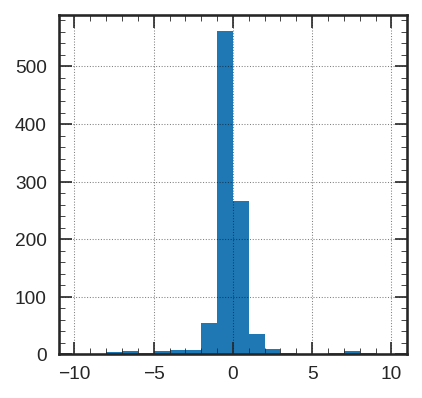

141 140
85 85
255 255
212 212
60 59
196 194
250 249
261 260
159 159
139 138
118 117
50 49
52 52
231 230
240 240
159 158
259 257
96 95
204 203
102 101


In [29]:
fig, ax = plt.subplots(1, 1, figsize=(3,3))
ax.hist(np.argmax(zone_featmaps_test2, axis=-1) - zone_box_anchors_test,
        bins=20, range=(-10,10))
plt.show()

for ievt in range(20):
  print(zone_box_anchors_test[ievt], np.argmax(zone_featmaps_test2[ievt]))

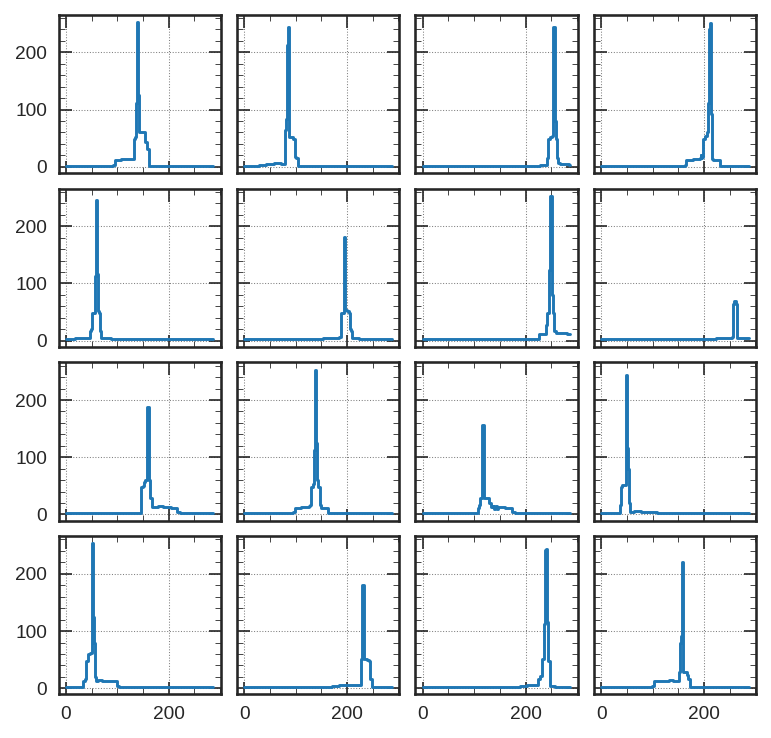

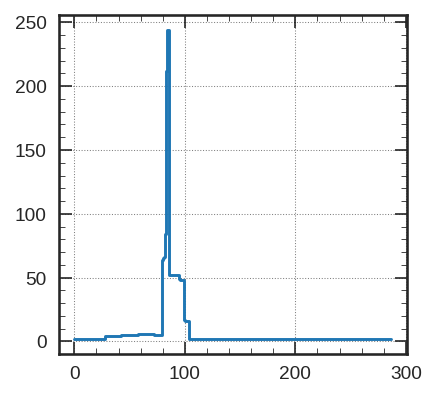

In [30]:
fig, axs = plt.subplots(4, 4, figsize=(6, 6),
                        sharex=True, sharey=True, gridspec_kw=dict(wspace=0.1, hspace=0.1))

for i in range(4):
  for j in range(4):
    ax = axs[i, j]
    ievt = (i * 4) + j
    ax.step(np.arange(num_cols), zone_featmaps_test2[ievt])

plt.show()

ievt = 1
fig, ax = plt.subplots(1, 1, figsize=(3,3))
plt.step(np.arange(num_cols), zone_featmaps_test2[ievt])
plt.show()

In [31]:
# Export data

for ievt in range(3):
  print('Event {0}'.format(ievt))
  fmap = zone_featmaps_test2[ievt].astype(np.int32)
  print(np.array2string(fmap, separator=', ', threshold=1000))
  print()

Event 0
[  2,   2,   2,   2,   2,   2,   2,   2,   2,   2,   2,   2,   2,   2,   2,
   2,   2,   2,   2,   2,   2,   2,   2,   2,   2,   2,   2,   2,   2,   2,
   2,   2,   2,   2,   2,   2,   2,   2,   2,   2,   2,   2,   2,   2,   2,
   2,   2,   2,   2,   2,   2,   2,   2,   2,   2,   2,   2,   2,   2,   2,
   2,   2,   2,   2,   2,   2,   2,   2,   2,   2,   2,   2,   2,   2,   2,
   2,   2,   2,   2,   2,   2,   2,   2,   2,   2,   2,   2,   2,   2,   2,
   2,   2,   2,   4,   4,   4,   4,  12,  12,  12,  12,  12,  12,  12,  12,
  12,  12,  12,  12,  13,  13,  13,  13,  13,  13,  13,  13,  13,  13,  13,
  13,  13,  13,  13,  13,  14,  14,  14,  14,  14,  14,  14,  14,  14,  48,
  48,  52, 112, 112, 240, 253, 253, 125, 124,  61,  61,  61,  60,  60,  60,
  60,  60,  60,  60,  48,  44,  44,  44,  44,  32,  32,  32,   2,   2,   2,
   2,   2,   2,   2,   2,   2,   2,   2,   2,   2,   2,   2,   2,   2,   2,
   2,   2,   2,   2,   2,   2,   2,   2,   2,   2,   2,   2,   2,   2,   2,
   2

In [32]:
# Non-maximum suppression

apply_nms = True

if apply_nms:
  x = zone_featmaps_test2
  x = tf.floor(x / 4)  # truncate last two bits
  x_left_1 = tf.roll(x, shift=1, axis=-1)    # left neighbor shifted to right
  x_right_1 = tf.roll(x, shift=-1, axis=-1)  # right neighbor shifted to left
  x_left_2 = tf.roll(x, shift=3, axis=-1)    # left neighbor shifted to right
  x_right_2 = tf.roll(x, shift=-3, axis=-1)  # right neighbor shifted to left
  x_center = x
  #mask = (x_center >= x_left_1) & (x_center > x_right_1)
  #mask = (x_center > x_left_1) & (x_center >= x_right_1)
  mask = (x_center > x_left_1) & (x_center >= x_right_1) & (x_center > x_left_2) & (x_center >= x_right_2)
  x *= tf.cast(mask, tf.float32)
  zone_featmaps_test3 = x.numpy()
else:
  zone_featmaps_test3 = zone_featmaps_test2

print('zone_featmaps_test3: {0}'.format(zone_featmaps_test3.shape))
print('.. max: {0}'.format(zone_featmaps_test3.max()))

zone_featmaps_test3: (1000, 288)
.. max: 63.0


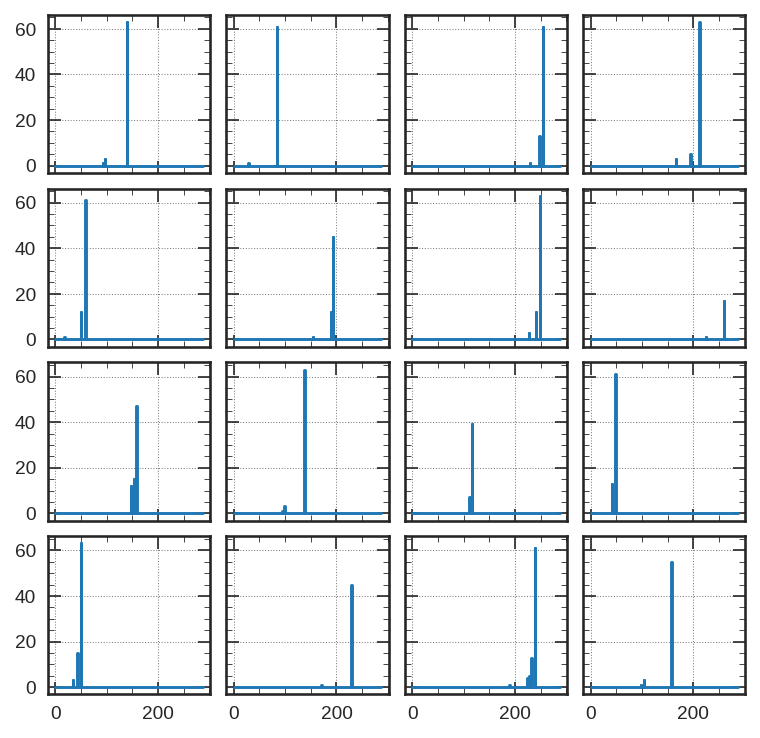

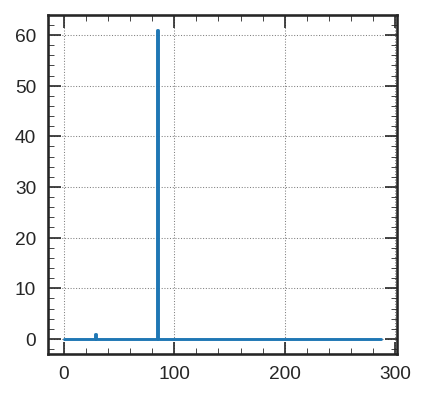

In [33]:
fig, axs = plt.subplots(4, 4, figsize=(6, 6),
                        sharex=True, sharey=True, gridspec_kw=dict(wspace=0.1, hspace=0.1))

for i in range(4):
  for j in range(4):
    ax = axs[i, j]
    ievt = (i * 4) + j
    ax.step(np.arange(num_cols), zone_featmaps_test3[ievt])

plt.show()

ievt = 1
fig, ax = plt.subplots(1, 1, figsize=(3,3))
plt.step(np.arange(num_cols), zone_featmaps_test3[ievt])
plt.show()

In [34]:
# Export data

for ievt in range(3):
  print('Event {0}'.format(ievt))
  fmap = zone_featmaps_test3[ievt].astype(np.int32)
  print(np.array2string(fmap, separator=', ', threshold=1000))
  print()

Event 0
[ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
  0,  0,  0,  1,  0,  0,  0,  3,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0, 63,  0,  0,  0,
  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0